 ##### Predict the price of the Uber ride from a given pickup point to the agreed drop-off loca- tion.  Perform following tasks: 
1.  Pre-process the dataset.
2.  Identify outliers.
3.  Check the correlation.  
4.   Implement linear regression and random forest regression models.
5.   Evaluate the models and compare their respective scores like R2, RMSE, etc.
Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset


In [1]:
# Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from  sklearn.model_selection  import  train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 1. Load data
df = pd.read_csv('uber.csv')
print("Dataset  head:") 
df.head()


Dataset  head:


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
# 2. Preprocess data
# Check for missing values 
print("\nMissing values per column:") 
print(df.isnull().sum())



Missing values per column:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [4]:
# Drop rows with missing values if any
df = df.dropna()



In [5]:
# Feature engineering: Convert datetime to useful features
df['pickup_datetime']  =  pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour 
df['dayofweek']  =  df['pickup_datetime'].dt.dayofweek


In [6]:
# Calculate haversine distance between pickup and dropoff
def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2]) 
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2  
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
df['dropoff_latitude'], df['dropoff_longitude'])


In [7]:
# Remove entries with zero or near-zero distance or fare (likely errors)
df = df[(df['distance_km'] > 0.01) & (df['fare_amount'] > 0)]

print(f"\nData shape after cleaning: {df.shape}")



Data shape after cleaning: (193868, 12)


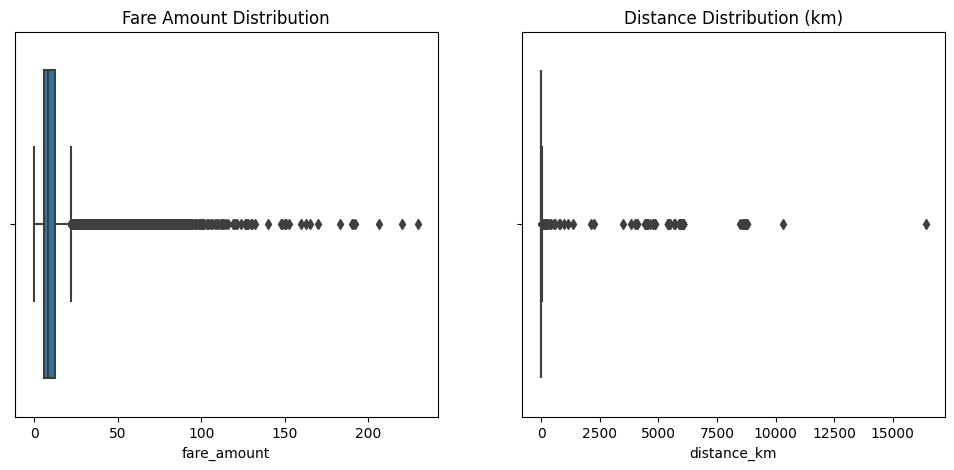


Data shape after removing outliers: (190709, 12)


In [8]:
# 3. Outlier detection - visualize fare and distance
plt.figure(figsize=(12,5))

plt.subplot(1,2,1) 
sns.boxplot(x=df['fare_amount']) 
plt.title("Fare Amount Distribution")

plt.subplot(1,2,2) 
sns.boxplot(x=df['distance_km']) 
plt.title("Distance Distribution (km)")

plt.show()

fare_99 = df['fare_amount'].quantile(0.99)  
dist_99  =  df['distance_km'].quantile(0.99)

df = df[(df['fare_amount'] <= fare_99) & (df['distance_km'] <= dist_99)] 
print(f"\nData shape after removing outliers: {df.shape}")


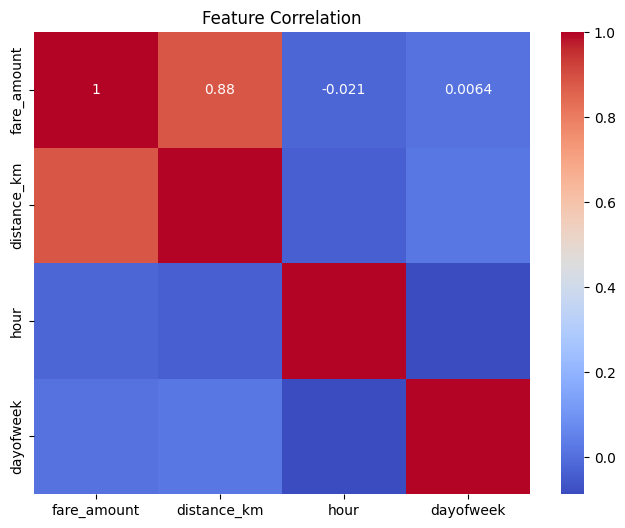

In [9]:
# 4. Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['fare_amount',  'distance_km',  'hour',  'dayofweek']].corr(),annot=True, cmap='coolwarm')
plt.title("Feature Correlation") 
plt.show()


In [10]:
# 5. Model preparation
features = ['distance_km', 'hour', 'dayofweek']
X = df[features]
y = df['fare_amount']


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# 6. Linear Regression model 
lr = LinearRegression() 
lr.fit(X_train, y_train) 
y_pred_lr = lr.predict(X_test)


In [12]:
# 7. Random Forest Regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42) 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [13]:
# 8. Evaluation function
def  evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, R2: {r2:.4f}")

evaluate(y_test, y_pred_lr, "Linear Regression") 
evaluate(y_test, y_pred_rf, "Random Forest")


Linear Regression - RMSE: 3.65, R2: 0.7715
Random Forest - RMSE: 3.77, R2: 0.7566


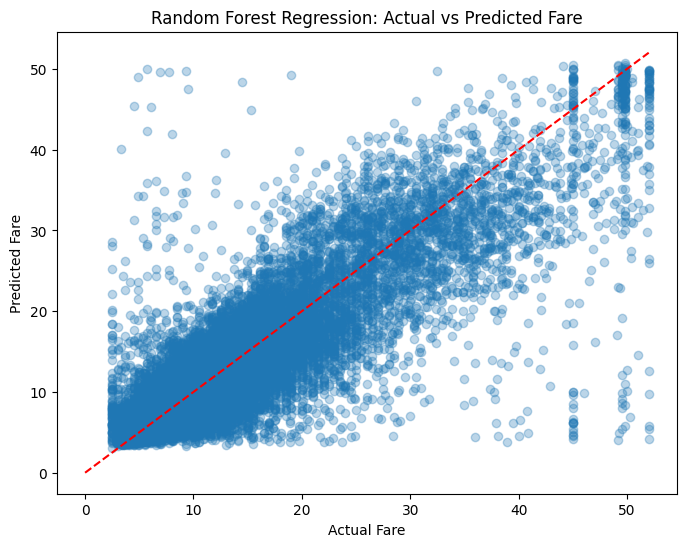

In [14]:
# 9. Visualize predictions vs actual for Random Forest (best model expected)
plt.figure(figsize=(8,6)) 
plt.scatter(y_test, y_pred_rf, alpha=0.3) 
plt.xlabel("Actual Fare") 
plt.ylabel("Predicted Fare")
plt.title("Random Forest Regression: Actual vs Predicted Fare") 
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--')	# diagonal line 
plt.show()
